# Preditor de valor de aluguel 

  A análise a seguir tem como objetivo estimar o valor de aluguel de apartamentos utilizando suas características como preditores. O dataset foi adquirido do banco de dados do Kaggle. O dataset foi construído pelo usuário Rubens Junior utilizando um webcrawler para adquirir dados de 10692 imóveis. https://www.kaggle.com/rubenssjr/brasilian-houses-to-rent. 

In [1]:
import pandas as pd
import scipy.stats as stats
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import explained_variance_score, mean_absolute_error, r2_score

import seaborn as sns
from matplotlib import pyplot as plt
sns.set()

In [2]:
imoveis_aluguel = pd.read_csv('~/Downloads/houses_to_rent_v2.csv')

In [3]:
imoveis_aluguel   

,city,area,rooms,bathroom,parking spaces,floor,animal,furniture,hoa (R$),rent amount (R$),property tax (R$),fire insurance (R$),total (R$)
0,São Paulo,70,2,1,1,7,acept,furnished,2065,3300,211,42,5618
1,São Paulo,320,4,4,0,20,acept,not furnished,1200,4960,1750,63,7973
2,Porto Alegre,80,1,1,1,6,acept,not furnished,1000,2800,0,41,3841
3,Porto Alegre,51,2,1,0,2,acept,not furnished,270,1112,22,17,1421
4,São Paulo,25,1,1,0,1,not acept,not furnished,0,800,25,11,836
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10687,Porto Alegre,63,2,1,1,5,not acept,furnished,402,1478,24,22,1926
10688,São Paulo,285,4,4,4,17,acept,not furnished,3100,15000,973,191,19260
10689,Rio de Janeiro,70,3,3,0,8,not acept,furnished,980,6000,332,78,7390
10690,Rio de Janeiro,120,2,2,2,8,acept,furnished,1585,12000,279,155,14020


In [4]:
imoveis_aluguel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10692 entries, 0 to 10691
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   city                 10692 non-null  object
 1   area                 10692 non-null  int64 
 2   rooms                10692 non-null  int64 
 3   bathroom             10692 non-null  int64 
 4   parking spaces       10692 non-null  int64 
 5   floor                10692 non-null  object
 6   animal               10692 non-null  object
 7   furniture            10692 non-null  object
 8   hoa (R$)             10692 non-null  int64 
 9   rent amount (R$)     10692 non-null  int64 
 10  property tax (R$)    10692 non-null  int64 
 11  fire insurance (R$)  10692 non-null  int64 
 12  total (R$)           10692 non-null  int64 
dtypes: int64(9), object(4)
memory usage: 1.1+ MB


In [5]:
#modificando os nomes de algumas colunas para facilitar o seu uso durante a análise

imoveis_aluguel.rename(columns={
    'rent amount (R$)': 'rent',
    'parking spaces': 'parking',
    'hoa (R$)': 'hoa',
    'property tax (R$)': 'tax',
    'fire insurance (R$)': 'fire_insurance',
    'total (R$)': 'total'
}, inplace = True)

In [6]:
imoveis_aluguel.describe()

,area,rooms,bathroom,parking,hoa,rent,tax,fire_insurance,total
count,10692.000000,10692.000000,10692.000000,10692.000000,1.069200e+04,10692.000000,10692.000000,10692.000000,1.069200e+04
mean,149.217920,2.506079,2.236813,1.609147,1.174022e+03,3896.247194,366.704358,53.300879,5.490487e+03
std,537.016942,1.171266,1.407198,1.589521,1.559231e+04,3408.545518,3107.832321,47.768031,1.648473e+04
min,11.000000,1.000000,1.000000,0.000000,0.000000e+00,450.000000,0.000000,3.000000,4.990000e+02
25%,56.000000,2.000000,1.000000,0.000000,1.700000e+02,1530.000000,38.000000,21.000000,2.061750e+03
50%,90.000000,2.000000,2.000000,1.000000,5.600000e+02,2661.000000,125.000000,36.000000,3.581500e+03
75%,182.000000,3.000000,3.000000,2.000000,1.237500e+03,5000.000000,375.000000,68.000000,6.768000e+03
max,46335.000000,13.000000,10.000000,12.000000,1.117000e+06,45000.000000,313700.000000,677.000000,1.120000e+06


In [14]:
imoveis_aluguel.floor.unique()

array(['7', '20', '6', '2', '1', '-', '4', '3', '10', '11', '24', '9',
       '8', '17', '18', '5', '13', '15', '16', '14', '26', '12', '21',
       '19', '22', '27', '23', '35', '25', '46', '28', '29', '301', '51',
       '32'], dtype=object)

In [7]:
#Com o sumário dos dados acima podemos ver que existem dois problemas: os andares (floor) estão como objeto. Visto que geralmente, em apartamentos, quanto mais alto for o imóvel, mais caro ele é
#O segundo problema é que existe um imóvel que está no 301º andar, provavelmente erro de digitação. Visto que o andar é possivelmente um preditor importante do valor do aluguél, decidi remover este registro do dataset
#Vamo também que o andar de alguns imóveis estão codificados como '-', talvez representando casa, apartamentos no térreo em prédios caixão, ou simplesmente algum erro.
#Decidi então por remover estes imóveis, e focar então somente em apartamentos


apartamentos = imoveis_aluguel[(imoveis_aluguel.floor != '-') & (imoveis_aluguel.floor != '301')]
apartamentos.loc[:,'floor'] = apartamentos['floor'].astype(int)

/home/vitorxl/miniconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1745: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(ilocs[0], value)


In [8]:
#Então criamos um modelo de regressão linear, usando todas as features/variáveis disponíveis no dataset para inferir o valor do alugel (rent)

apt = pd.get_dummies(apartamentos)

X = apt.drop(['rent'], axis = 1)
y = apt['rent']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
ev_reg = explained_variance_score(y_test, y_pred)
mae_reg = mean_absolute_error(y_test, y_pred)
r2_reg = r2_score(y_test, y_pred)
print('Explained variance: ', ev_reg)
print('Mean Absolute Error: ', mae_reg)
print('R²: ', r2_reg)

Explained variance:  0.9999928310767621
Mean Absolute Error:  0.7627882082271521
R²:  0.9999928305046706


<AxesSubplot:>

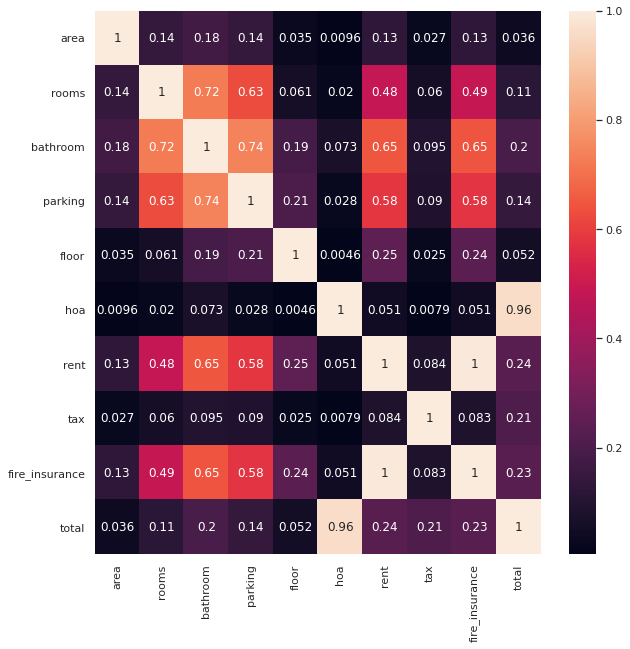

In [9]:
#O print das medidas de acurácio do modelo retornam valores muito altos, como o R² e a Explained Variance próximos a 1.0. Seria um ótimo resultado, no entanto é irreal
#Diversos fatores que podem causar variação significativa no valor do aluguel não estão presentes no dataset como: proximidade de pontos importantes da cidade ou de transporte público, condições das vias, idade do imóvel, condições socio-econômicas da região, etc.
#Então seria esperado que os preditores tivessem uma performance muito inferior ao que foi mostrado acima.
#Então vamos analisar com mais cuidados as feautures

plt.figure(figsize=(10,10))
sns.heatmap(apartamentos.corr(), annot = True)

#O heatmap abaixo, construído a partir de uma correlação de Pearson, mostra uma correlação perfeita com fire_insurance
#O valor de fire_insurance é provavelmente algum artifício do do webcrawler utilizado pelo autor do dataset.


In [10]:
#Podemos também verificar que os valores de variance inflation factor de 'hoa', 'tax', 'fire_insurance' e 'total' são extremamente elevados.
#Estes valores indicam multicolinearidade, então foram removidos dos modelos seguintes.

vif_data = pd.DataFrame() 
vif_data["feature"] = X.columns 
  
vif_data["VIF"] = [variance_inflation_factor(X.values, i) 
                          for i in range(len(X.columns))] 
vif_data

/home/vitorxl/miniconda3/lib/python3.8/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


,feature,VIF
0,area,1.034687
1,rooms,2.397748
2,bathroom,3.443216
3,parking,2.604649
4,floor,1.123369
5,hoa,4223.957181
6,tax,166.203051
7,fire_insurance,132.830652
8,total,4638.473846
9,city_Belo Horizonte,inf


In [16]:
features = ['rent', 'city', 'rooms', 'bathroom', 'floor', 'furniture', 'animal','parking', 'area']
apartamentos = apartamentos[features]

In [19]:
#Repetimos então o modelo gerado acima, utilizando somente as features selecionadas para prever o 'rent'

apartamentos_dummies = pd.get_dummies(apartamentos)

X = apartamentos_dummies.drop(['rent'], axis = 1)
y = apartamentos_dummies['rent']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
ev_reg = explained_variance_score(y_test, y_pred)
mae_reg = mean_absolute_error(y_test, y_pred)
r2_reg = r2_score(y_test, y_pred)
print('Explained variance: ', ev_reg)
print('Mean Absolute Error: ', mae_reg)
print('R²: ', r2_reg)

Explained variance:  0.49674184022408285
Mean Absolute Error:  1457.2883786379252
R²:  0.496710536000582


## Abaixo me aprofundo nas features selecionadas, tentando encontrar padrões, e limpo alguns outliers que provavelmente são erros de digitação dos valores nos sites onde o webcrawler foi utilizado.

In [20]:
apartamentos.furniture.value_counts()

not furnished    5978
furnished        2252
Name: furniture, dtype: int64

In [21]:
apartamentos.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8230 entries, 0 to 10690
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rent       8230 non-null   int64 
 1   city       8230 non-null   object
 2   rooms      8230 non-null   int64 
 3   bathroom   8230 non-null   int64 
 4   floor      8230 non-null   int64 
 5   furniture  8230 non-null   object
 6   animal     8230 non-null   object
 7   parking    8230 non-null   int64 
 8   area       8230 non-null   int64 
dtypes: int64(6), object(3)
memory usage: 643.0+ KB


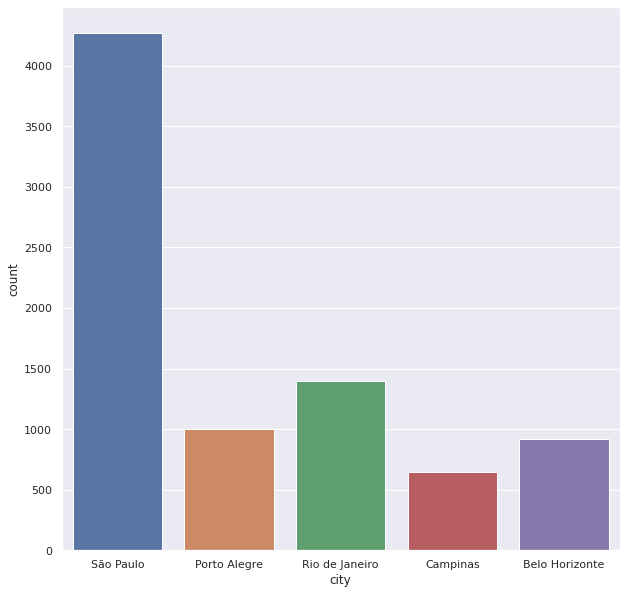

In [22]:
plt.figure(figsize = (10, 10))
sns.countplot(x = 'city', data = apartamentos)
plt.show()

In [23]:
apartamentos.area.describe()

count     8230.000000
mean       124.585176
std        601.070648
min         11.000000
25%         54.000000
50%         80.000000
75%        141.000000
max      46335.000000
Name: area, dtype: float64

In [24]:
apartamentos.area.sort_values(ascending = False).head(20)

2397     46335
5915     24606
9241     12732
8790      2000
1250      1000
10184     1000
6615      1000
3772       950
421        900
4114       900
7679       884
8397       856
5293       850
3533       800
8425       758
2097       720
8399       717
5481       700
9085       690
2697       685
Name: area, dtype: int64

In [25]:
apartamentos = apartamentos[apartamentos.area < 2000]
apartamentos.area.describe()

count    8226.000000
mean      114.230853
std        95.448864
min        11.000000
25%        54.000000
50%        80.000000
75%       140.750000
max      1000.000000
Name: area, dtype: float64

<AxesSubplot:xlabel='area', ylabel='Count'>

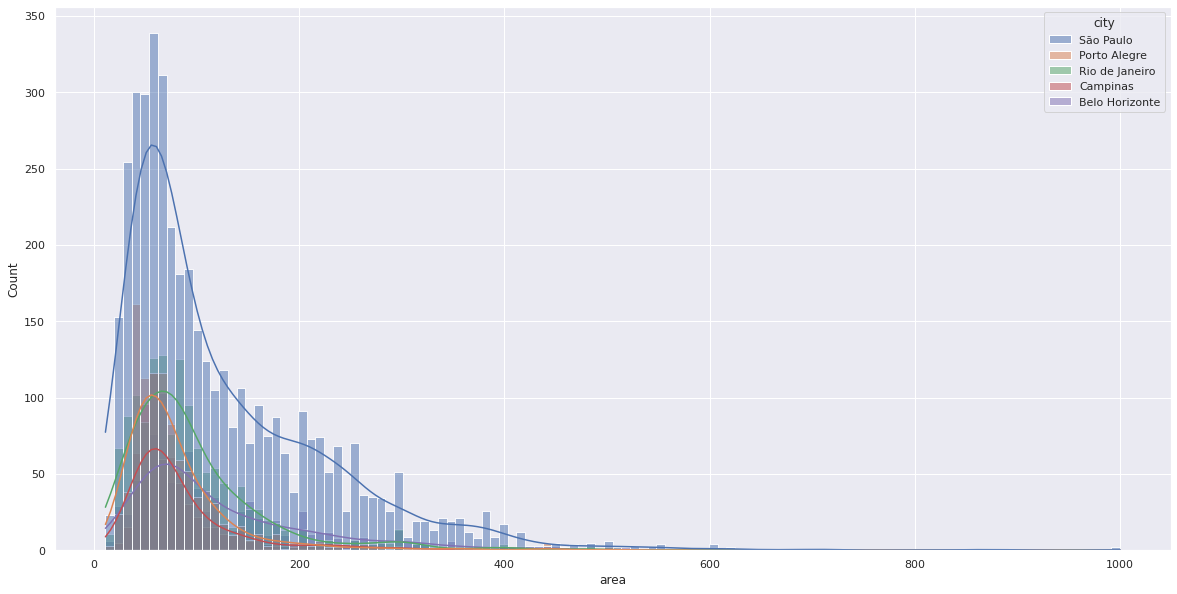

In [26]:
plt.figure(figsize = (20, 10))
sns.histplot(data = apartamentos, x = 'area', kde = True, hue = 'city')

<AxesSubplot:xlabel='area', ylabel='Count'>

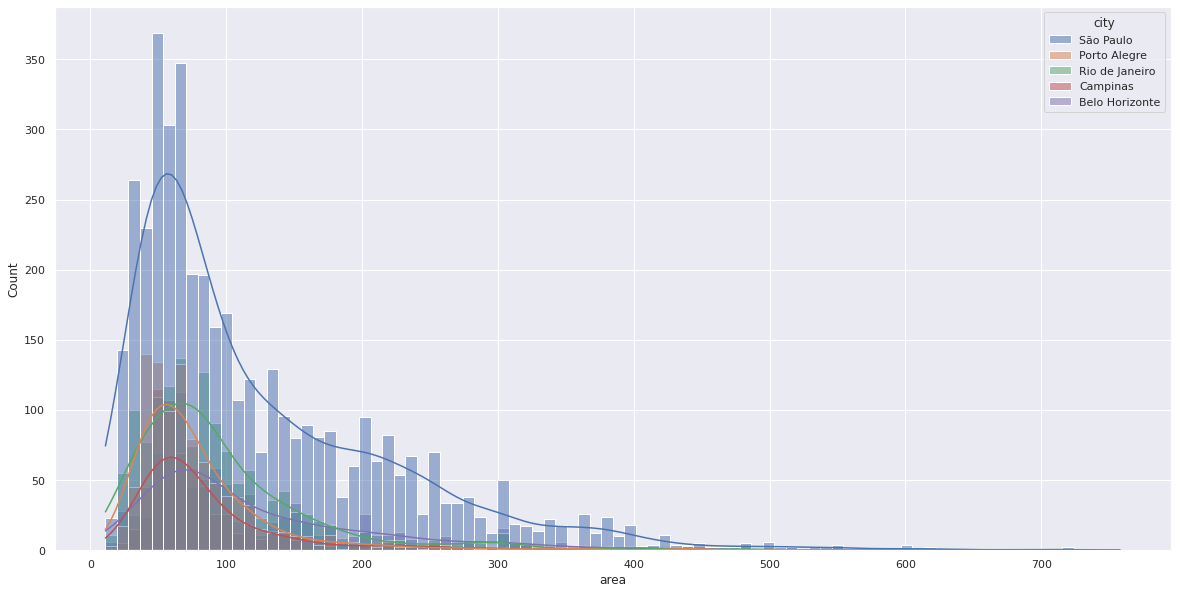

In [27]:
plt.figure(figsize = (20, 10))
sns.histplot(data = apartamentos[apartamentos.area < 800], x = 'area', kde = True, hue = 'city')

<AxesSubplot:xlabel='city', ylabel='area'>

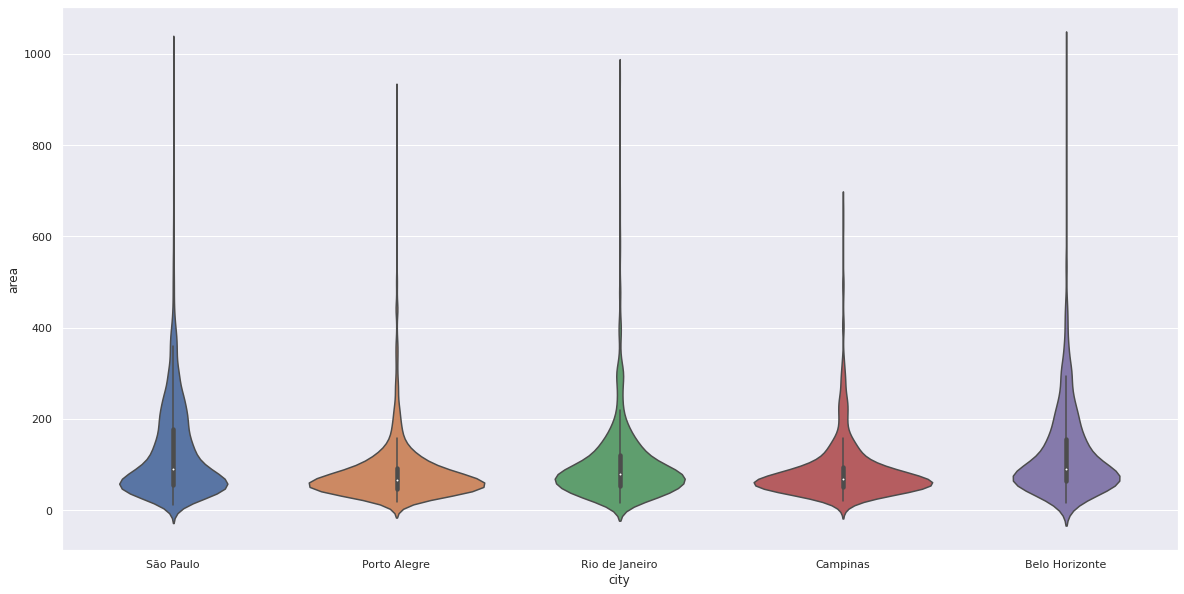

In [28]:
plt.figure(figsize=(20,10))
sns.violinplot(data = apartamentos, x = 'city', y = 'area')

<AxesSubplot:xlabel='area', ylabel='rent'>

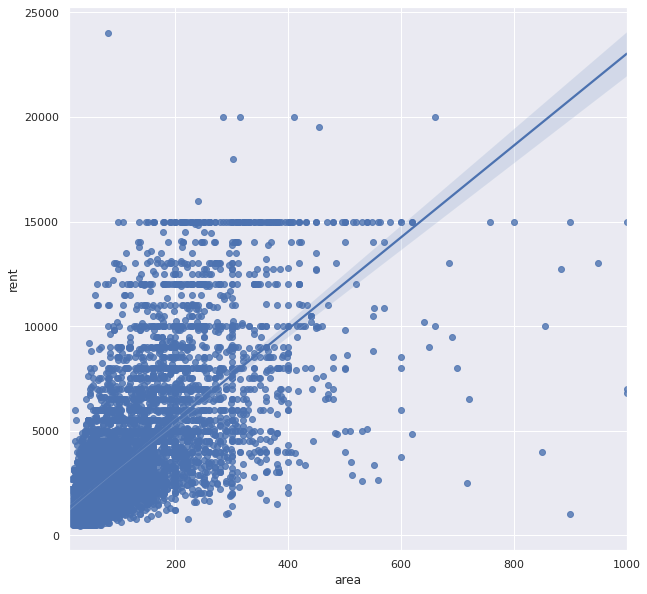

In [29]:
plt.figure(figsize=(10,10))
sns.regplot(data = apartamentos, x = 'area', y = 'rent')

<AxesSubplot:xlabel='rent', ylabel='animal'>

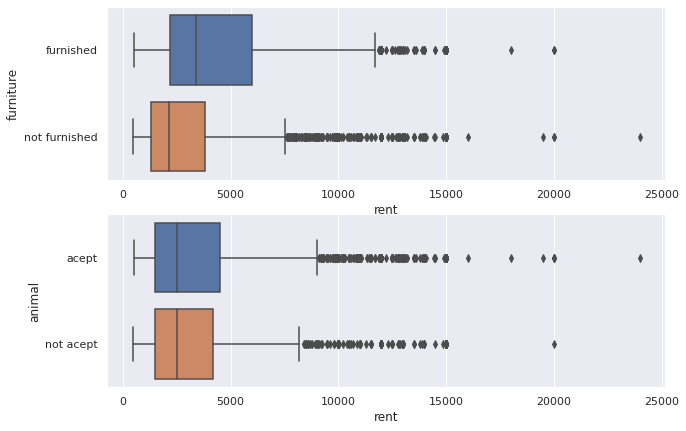

In [30]:
fig, axes = plt.subplots(2, 1, figsize = (10, 7))
sns.boxplot(ax = axes[0], data = apartamentos, orient = 'h', x = 'rent', y = 'furniture')
sns.boxplot(ax = axes[1], data = apartamentos, orient = 'h', x = 'rent', y = 'animal')

In [31]:
#Podemos confirmar então que se o apartamento aceita ou não animais não tem influência no valor do aluguel
fit = ols('rent ~ animal', data = apartamentos).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rent   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.399
Date:                Sun, 13 Dec 2020   Prob (F-statistic):              0.237
Time:                        18:22:47   Log-Likelihood:                -77902.
No. Observations:                8226   AIC:                         1.558e+05
Df Residuals:                    8224   BIC:                         1.558e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept            3603.8110     39.480     91.282      0.000    3526.420    3681.202
animal[T.not acept]   -96.9772     81.975     -1.183      0.237    -257.669      63.715
==============================================================================
Omnibus:                     3002.389   Durbin-Watson:                   2.017
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9524.312
Skew:                           1.910   Prob(JB):                         0.00
Kurtosis:                       6.632   Cond. No.                         2.52
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [32]:
fit = ols('rent ~ furniture', data = apartamentos).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   rent   R-squared:                       0.040
Model:                            OLS   Adj. R-squared:                  0.040
Method:                 Least Squares   F-statistic:                     342.6
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           5.68e-75
Time:                        18:22:52   Log-Likelihood:                -77735.
No. Observations:                8226   AIC:                         1.555e+05
Df Residuals:                    8224   BIC:                         1.555e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                   4604.0400     64.826     71.021      0.000    4476.964    4731.116
furniture[T.not furnished] -1407.7838     76.057    -18.510      0.000   -1556.875   -1258.693
==============================================================================
Omnibus:                     3071.218   Durbin-Watson:                   2.018
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            10206.925
Skew:                           1.933   Prob(JB):                         0.00
Kurtosis:                       6.851   Cond. No.                         3.59
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [38]:
features = ['rent', 'city', 'rooms', 'bathroom', 'floor', 'furniture', 'parking', 'area']
apartamentos = apartamentos[features]

In [39]:

apartamentos_dummies = pd.get_dummies(apartamentos)

X = apartamentos_dummies.drop(['rent'], axis = 1)
y = apartamentos_dummies['rent']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 1)
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
ev_reg = explained_variance_score(y_test, y_pred)
mae_reg = mean_absolute_error(y_test, y_pred)
r2_reg = r2_score(y_test, y_pred)
print('Explained variance: ', ev_reg)
print('Mean Absolute Error: ', mae_reg)
print('R²: ', r2_reg)

Explained variance:  0.5856723216988469
Mean Absolute Error:  1288.709324481724
R²:  0.5856693896842255


Após limpar alguns outliers, e remover a feature 'animal', chegamos a uma performence maior em comparação ao modelo inicial.